In [1]:
!pip install plotly

In [2]:
import os
import random
from tqdm import tqdm

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
data_dir = 'data'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

print(train_dataset)
print(test_dataset)
type(train_dataset)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.7MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test


torchvision.datasets.mnist.FashionMNIST

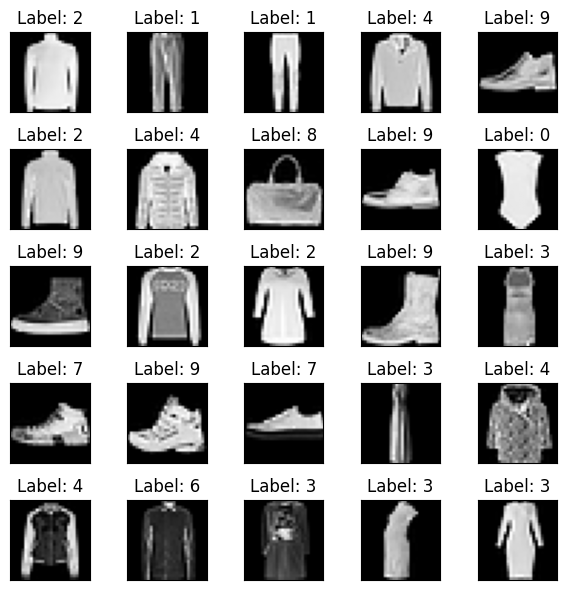

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()


In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

In [6]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])


In [7]:
batch_size=64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [8]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


In [9]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim=128):
        super().__init__()

        # Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        # Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


In [10]:
# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
dim = 4

encoder = Encoder(encoded_space_dim=dim, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=dim, fc2_input_dim=128)


In [11]:
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)


Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [12]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [13]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, n_epochs, epoch):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    total_steps = len(dataloader)
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for step, (image_batch, _) in enumerate(dataloader, start=1): # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress = int(step / total_steps * 100)
        if progress % 10 == 0 and step != total_steps:
            print(f"\rEpoch {epoch+1}/{n_epochs} | {progress}% done", end="")
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [14]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [15]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()


In [16]:
num_epochs = 30
# Попередньо задаємо словник для зберігання історії (якщо його ще немає)
diz_loss = {'train_loss':[], 'val_loss':[]} 

# Запускаємо цикл по епохах
for epoch in range(num_epochs):
    # ПЕРЕДАЄМО epoch і num_epochs у функцію!
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        epoch=epoch,     # <--- Ось чого не вистачало
        n_epochs=num_epochs # <--- І цього
    )
    
    # Те саме для валидації (якщо ти і там змінив аргументи)
    val_loss = test_epoch(encoder, decoder, device, valid_loader, loss_fn)
    
    # Зберігаємо історію та виводимо результат
    print(f'\nEpoch {epoch+1}/{num_epochs} \t Train loss: {train_loss:.4f} \t Val loss: {val_loss:.4f}')
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)

Epoch 1/30 | 90% done
Epoch 1/30 	 Train loss: 0.0530 	 Val loss: 0.0244
Epoch 2/30 | 90% done
Epoch 2/30 	 Train loss: 0.0231 	 Val loss: 0.0220
Epoch 3/30 | 90% done
Epoch 3/30 	 Train loss: 0.0216 	 Val loss: 0.0213
Epoch 4/30 | 90% done
Epoch 4/30 	 Train loss: 0.0210 	 Val loss: 0.0207
Epoch 5/30 | 90% done
Epoch 5/30 	 Train loss: 0.0206 	 Val loss: 0.0204
Epoch 6/30 | 90% done
Epoch 6/30 	 Train loss: 0.0203 	 Val loss: 0.0202
Epoch 7/30 | 90% done
Epoch 7/30 	 Train loss: 0.0201 	 Val loss: 0.0201
Epoch 8/30 | 90% done
Epoch 8/30 	 Train loss: 0.0200 	 Val loss: 0.0200
Epoch 9/30 | 90% done
Epoch 9/30 	 Train loss: 0.0198 	 Val loss: 0.0200
Epoch 10/30 | 90% done
Epoch 10/30 	 Train loss: 0.0197 	 Val loss: 0.0198
Epoch 11/30 | 90% done
Epoch 11/30 	 Train loss: 0.0196 	 Val loss: 0.0198
Epoch 12/30 | 90% done
Epoch 12/30 	 Train loss: 0.0196 	 Val loss: 0.0197
Epoch 13/30 | 90% done
Epoch 13/30 	 Train loss: 0.0195 	 Val loss: 0.0197
Epoch 14/30 | 90% done
Epoch 14/30 	 Train 

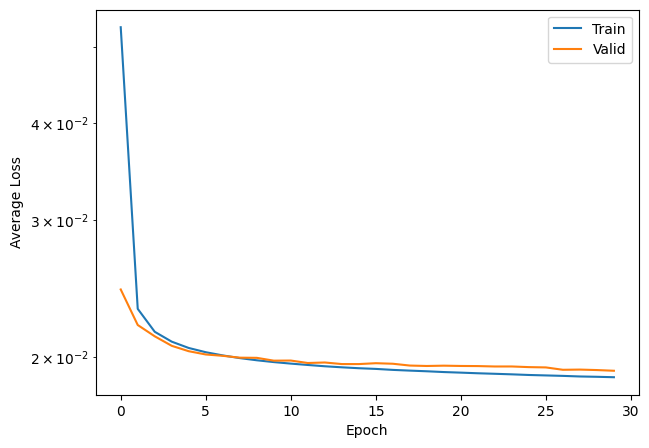

In [17]:
# Train and validation loss

plt.figure(figsize=(7,5))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.3390,  0.0167,  0.6595, -0.0196])
tensor([0.4115, 0.8175, 0.6856, 0.8422])


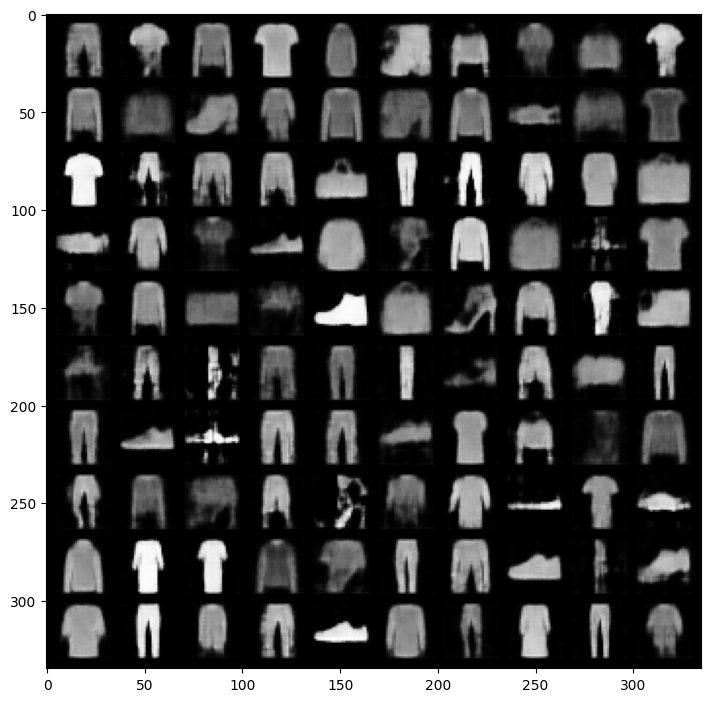

In [18]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_top_n(encoder, decoder, dataset, n=10):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # calculate mean and std of latent code, generated takining in test images as inputs 
        images, labels = map(list, zip(*[dataset[i] for i in range(10)]))
        images = torch.stack(images).to(device)
        latent = encoder(images)
        latent = latent.cpu()

        mean = latent.mean(dim=0)
        print(mean)
        std = (latent - mean).pow(2).mean(dim=0).sqrt()
        print(std)

        # sample latent vectors from the normal distribution
        latent = torch.randn(128, dim)*std + mean

        # reconstruct images from the random latent vectors
        latent = latent.to(device)
        img_recon = decoder(latent)
        img_recon = img_recon.cpu()

        fig, ax = plt.subplots(figsize=(20, 8.5))
        show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
        plt.show()
        
show_top_n(encoder, decoder, test_dataset, n=10)
